# Bin Data Examples

## import packages

In [1]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPSat import get_data_path
from GPSat.bin_data import BinData
from GPSat.dataprepper import DataPrep
from GPSat.dataloader import DataLoader
from GPSat.utils import WGS84toEASE2, EASE2toWGS84, cprint, stats_on_vals
from GPSat.plot_utils import plot_wrapper

## parameters

In [2]:

val_col = 'z'

by_cols = ['t', 'source']
val_col = val_col
x_col = 'x'
y_col = 'y'
grid_res = 50_000
x_range = [-4_500_000.0, 4_500_000.0]
y_range = [-4_500_000.0, 4_500_000.0]

lat_0, lon_0 = 90, 0

# plotting
# extent = [lon min, lat max, lat min, lat max]
extent = [-180, 180, 60, 90]

# which projection to use: "north" or "south"
projection = "north"

## read in raw data

in this case from several csv files

In [3]:


df = DataLoader.read_flat_files(file_dirs=get_data_path("example"),
                                file_regex="_RAW\.csv$",
                                col_funcs={
                                    "source": {
                                        "func": lambda x: re.sub('_RAW.*$', '', os.path.basename(x)),
                                        "filename_as_arg": True
                                    }
                                })

# convert lon, lat, datetime to x, y, t - to be used as the coordinate space
# - these could be included in the col_funcs
df['x'], df['y'] = WGS84toEASE2(lon=df['lon'], lat=df['lat'], lat_0=lat_0, lon_0=lon_0)
df['t'] = df['datetime'].values.astype("datetime64[D]").astype(float)

----------------------------------------------------------------------------------------------------
reading files from:
/home/runner/work/GPSat/GPSat/data/example/
that match regular expression: _RAW\.csv$


'read_from_multiple_files': 0.923 seconds


## Statistic on Values
it is useful to look at summary statistic on values to get an idea how it should be processed

In [4]:

sov = stats_on_vals(vals=df[val_col].values, name=val_col)

cprint("-" * 10, "BOLD")
cprint(f"Stats on '{val_col}' column", "OKCYAN")
cprint(sov, "OKBLUE")

'stats_on_vals': 0.330 seconds
----------
Stats on 'z' column
                      z
measure               z
size            1174848
num_not_nan     1174848
num_inf               0
min            -16.7965
mean           0.128416
max             16.7093
std            0.186566
skew         -10.912819
kurtosis     890.268297
q0.010          -0.3732
q0.050          -0.1387
q0.100          -0.0485
q0.200           0.0322
q0.300           0.0767
q0.400           0.1101
q0.500           0.1394
q0.600           0.1686
q0.700           0.2011
q0.800           0.2424
q0.900           0.3067
q0.950           0.3632
q0.990           0.4775


## DataPrep.bin_data_by: 2d binning



In [5]:


bin_ds = DataPrep.bin_data_by(df=df.loc[(df['z'] > -0.35) & (df['z'] < 0.65)],
                              by_cols=by_cols,
                              val_col=val_col,
                              x_col=x_col,
                              y_col=y_col,
                              grid_res=grid_res,
                              x_range=x_range,
                              y_range=y_range,
                              return_df=False)

'bin_data_by': 1.624 seconds


## plot results

'stats_on_vals': 0.003 seconds
plotting pcolormesh...
'plot_pcolormesh': 0.042 seconds
plotting hist (using all data)...
'plot_hist': 0.066 seconds


'plot_wrapper': 0.196 seconds


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/opt/hostedtoolcache/Python/3.11.9/x64/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


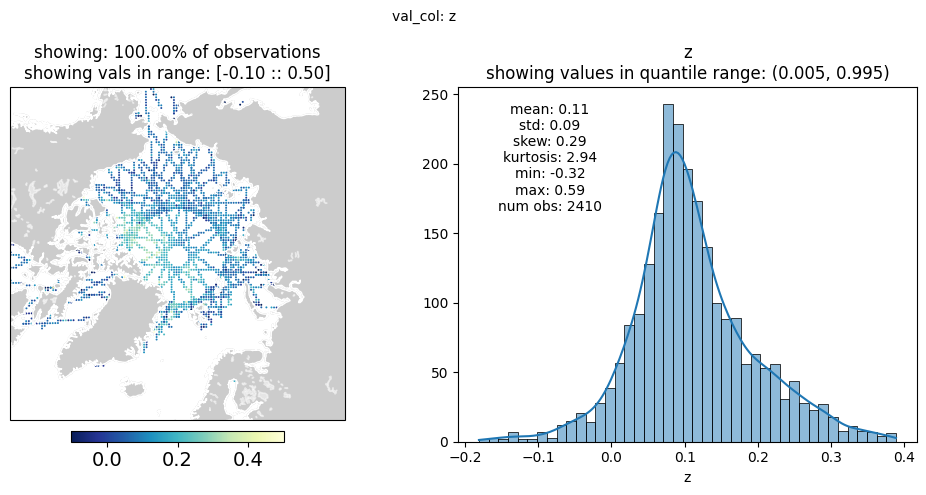

In [6]:

# bin_data_by returns a Dataset, unless return_df = True
# - drop nans and reset index
bin_df = bin_ds.to_dataframe().dropna().reset_index()

# this will plot all observations, some on top of each other
bin_df['lon'], bin_df['lat'] = EASE2toWGS84(bin_df['x'], bin_df['y'],
                                            lat_0=lat_0, lon_0=lon_0)

mid_t = np.median(bin_df['t'])

fig, stats_df = plot_wrapper(plt_df=bin_df.loc[bin_df['t'] == mid_t],
                             val_col=val_col,
                             max_obs=500_000,
                             vmin_max=[-0.1, 0.5],
                             projection=projection,
                             extent=extent)

plt.show()

## apply 1-d binning
demonstrated by a toy example

In [7]:


# -
# generate toy data
# -

N = 10001

np.random.seed(0)
# tf.random.set_seed(0)

# Build inputs X
X = np.linspace(0, 4 * np.pi, N)[:, None]  # X must be of shape [N, 1]

# Deterministic functions in place of latent ones
f1 = np.sin
f2 = np.cos

# Use transform = exp to ensure positive-only scale values
transform = np.exp

# Compute loc and scale as functions of input X
loc = f1(X)
scale = transform(f2(X))

# Sample outputs Y from Gaussian Likelihood
# - scale is standard deviation
Y = np.random.normal(loc, scale)

# store data in DataFrame (bin_data_by expects DataFrame atm)
# - by is a dummy column, currently need
df_dummy = pd.DataFrame({"x": X[:,0], "y": Y[:,0], 'by': 1})

Bin 1d Data

In [8]:

# TODO: just use bin_data ? needs to be modified
bdf = DataPrep.bin_data_by(df=df_dummy,
                           x_col='x',
                           val_col='y',
                           by_cols='by',
                           # bin_statistic=[np.mean, np.var, len],
                           bin_statistic=["mean", "std", "count"],
                           x_range=[0, 4 * np.pi],
                           grid_res=0.1,
                           bin_2d=False,
                           return_df=True)

bdf.reset_index(inplace=True)
bdf.drop("by", axis=1, inplace=True)

'bin_data_by': 1.554 seconds


plot binned results with original obs

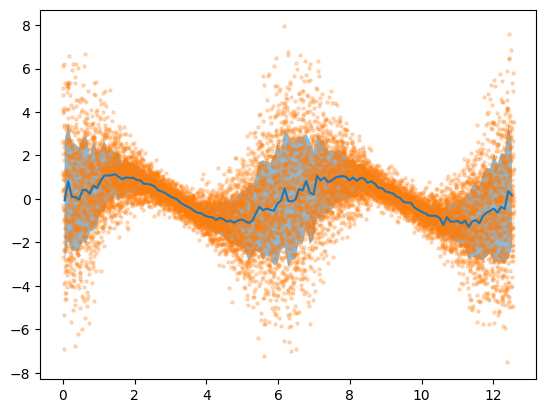

In [9]:

plt.plot(bdf['x'], bdf['y_mean'])
# plt.fill_between(bdf['x'],  bdf['y_mean'] + np.sqrt(bdf['y_var']),  bdf['y_mean'] - np.sqrt(bdf['y_var']),
#                  alpha=0.5)
plt.fill_between(bdf['x'],
                 bdf['y_mean'] + bdf['y_std'],
                 bdf['y_mean'] - bdf['y_std'],
                 alpha=0.5)
# plt.plot(bdf['x'], bdf['y_mean'] + np.sqrt(bdf['y_var']))
# plt.plot(bdf['x'], bdf['y_mean'] - np.sqrt(bdf['y_var']))
plt.scatter(X[:,0], Y[:,0], s=5, alpha=0.25)
plt.show()


# -
# identify tracks - apply 1d binning
# -

## BinData class

In [10]:

# TODO: save data as parquet file

# useful when have large amount of data in a single hdf5 file
# - allows for reading data in by batches

parq_tmp = get_data_path("example", "tmp.parquet")
df['date'] = df['datetime'].astype('datetime64[D]')

df.to_parquet(parq_tmp, engine="fastparquet")

## bin config
same parameters used by DataPrep.bin_data_by

In [11]:


bin_config = {
    'grid_res': 50000,
    'by_cols': ['source', 'date'],
    'val_col': val_col,
    'bin_statistic': 'mean',
    'row_select': [{'col': val_col, 'comp': '>=', 'val': -2.0},
                   {'col': val_col, 'comp': '<=', 'val': 2.0}],
    'x_col': 'x',
    'y_col': 'y',
    'x_range': [-4500000.0, 4500000.0],
    'y_range': [-4500000.0, 4500000.0]
}

bin data

NOTE: this class is currently a work in progress, effectively acts as a wrapper for DataPrep.bin_data_by and stats_on_vals

In [12]:

bd = BinData()

# if load_by is not specified will read data in by unique by_cols (from bin_config)
bin_df, stats = bd.bin_data(source=parq_tmp,
                            batch=False,
                            bin_config=bin_config)

will bin data all at once


'data_select': 0.424 seconds
'load': 0.425 seconds
getting stats on column: z from data


'stats_on_vals': 0.255 seconds
binning data...
'data_select': 0.058 seconds


'bin_data_by': 1.771 seconds
'bin_data_all_at_once': 2.480 seconds


view results

In [13]:

cprint("-" * 20, "BOLD")
cprint("bin_df:")
cprint("head", "OKCYAN")
cprint(bin_df.head(5), "OKBLUE")
cprint("dtypes", "OKCYAN")
cprint(bin_df.dtypes, "OKBLUE")

cprint("-" * 20, "BOLD")
cprint("stats:")
cprint(stats, "OKBLUE")



--------------------
bin_df:
head
           y          x source       date         z
0 -2475000.0  1125000.0      B 2020-03-06  0.181500
1 -2225000.0 -1525000.0      A 2020-03-10  0.198300
2 -2225000.0 -1425000.0      B 2020-03-01  0.231700
3 -2175000.0 -1625000.0      A 2020-03-06 -0.005200
4 -2175000.0 -1575000.0      A 2020-03-06 -0.052156
dtypes
y                float64
x                float64
source            object
date      datetime64[ns]
z                float64
dtype: object
--------------------
stats:
                      z
measure               z
size            1174848
num_not_nan     1174848
num_inf               0
min            -16.7965
mean           0.128416
max             16.7093
std            0.186566
skew         -10.912819
kurtosis     890.268297
q0.001        -1.087376
q0.010          -0.3732
q0.050          -0.1387
q0.100          -0.0485
q0.200           0.0322
q0.300           0.0767
q0.400           0.1101
q0.500           0.1394
q0.600           0.1686


write to file

In [14]:

# bin_df.to_parquet("/path/to/binned_data.parquet", engine="fastparquet")

